## Modelo de Identificación de Alta Conductividad en Canal de Drenaje de Molinos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import funciones
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score, precision_score, recall_score, silhouette_score

#### Carga del Dataset (Variables del Sistema de Control)

In [2]:
# Windows
#df_raw = pd.read_csv(r'C:\Users\sbarrios\OneDrive - Universidad Galileo\Data Science\Python\Proyectos\Pruebas\Pantaleon\Indeterminadas\Trazas\Drenaje_Canal_Molinos_Dic_V1.csv')
df_raw = pd.read_csv('Drenaje_Canal_Molinos_Dic_V1.csv')

# macOS
#df_raw = pd.read_csv(r'/Users/sergiobarrios/Library/CloudStorage/OneDrive-UniversidadGalileo/Data Science/Python/Proyectos/Pruebas/Pantaleon/Indeterminadas/Datos/Drenaje_Canal_Molinos_Dic_V1.csv')

# Imputación de Medias por Día para Valores faltantes o con Error
df = funciones.imputacion_media_dia(df_raw)

# Creación de Dos Nuevas Features (Desbalance de Niveles entre Filtrado y Mezclado)
df["Desbalance Filtrado Mezclado TA"] = df["Nivel Tanque Jugo Filtrado TA"] - df["Nivel Tanque Jugo Mezclado TA"]
df["Desbalance Filtrado Mezclado TB"] = df["Nivel Tanque Jugo Filtrado T-B"] - df["Nivel Tanque Jugo Mezclado T-B"]

df

,Flujo agua asepsia Patio T-A,Flujo agua asepsia Patio T-A_STD,Flujo agua asepsia Molinos T-A,Flujo agua asepsia Molinos T-A_STD,Flujo agua asepsia Molinos T-B,Flujo agua asepsia Molinos T-B_STD,Flujo Agua de Asepsia a Patio T-B,Flujo Agua de Asepsia a Patio T-B_STD,Nivel Chute Molino No. 1 TA,Nivel Chute Molino No. 1 TA_STD,...,Nivel Tanque Jugo Mezclado TA_STD,Nivel Tanque Jugo Filtrado TA,Nivel Tanque Jugo Filtrado TA_STD,Nivel Tanque Jugo Mezclado T-B,Nivel Tanque Jugo Mezclado T-B_STD,Nivel Tanque Jugo Filtrado T-B,Nivel Tanque Jugo Filtrado T-B_STD,Canal de drenaje de molinos,Desbalance Filtrado Mezclado TA,Desbalance Filtrado Mezclado TB
0,0.0,0.0,0.380069,1.900507,8.299759,24.195318,0.008086,0.053189,2.584282,0.091732,...,0.023592,99.999992,0.000000,50.028769,3.230097,45.103410,4.367220,256.444069,0.082185,-4.925360
1,0.0,0.0,0.356296,1.846135,5.666450,20.554662,18.135944,41.708672,11.649082,11.728414,...,22.549044,93.664376,21.002234,49.969765,1.942055,44.916065,3.508370,472.186639,-0.558685,-5.053700
2,0.0,0.0,0.059569,0.797475,8.232153,24.209229,0.013565,0.067979,9.437822,13.021465,...,24.917524,45.150503,7.246251,49.938687,3.753935,44.615220,6.670093,430.638120,22.247251,-5.323466
3,0.0,0.0,0.000000,0.000000,9.686621,21.560862,0.023860,0.090426,19.254145,16.693070,...,5.999161,45.121785,8.032043,50.057485,2.710876,45.240134,5.066420,178.956105,-0.020247,-4.817351
4,0.0,0.0,0.000000,0.000000,9.867392,23.089147,0.021480,0.085804,15.320077,17.107387,...,2.041549,45.127014,4.017310,50.028702,3.482143,45.003120,7.709161,189.074936,0.094567,-5.025582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,0.0,0.0,25.878148,56.870314,5.263848,6.506316,0.002602,0.029410,31.583273,23.010844,...,6.021523,45.268369,7.666305,45.089897,2.236749,53.368682,9.377704,17.375843,1.526597,8.278784
1116,0.0,0.0,24.882381,51.882539,6.944293,6.670061,26.446321,68.358698,42.449861,20.172792,...,3.624528,47.615102,6.884198,45.097966,4.795033,48.433202,10.252822,44.771925,2.751816,3.335236
1117,0.0,0.0,8.052492,29.907847,0.317015,1.641151,76.253293,100.814388,39.232567,22.841739,...,2.917006,51.052372,9.216957,44.974490,2.164418,52.976618,9.109991,19.730241,5.988560,8.002129
1118,0.0,0.0,0.078849,0.160685,1.783397,3.605508,10.809724,45.558004,20.155612,23.757738,...,12.881621,48.862905,13.011732,45.035900,2.964560,47.030010,7.672893,17.181516,12.478180,1.994110


### Distribución de Frecuencias Valores de Conductividad

<AxesSubplot:xlabel='Canal de drenaje de molinos', ylabel='Count'>

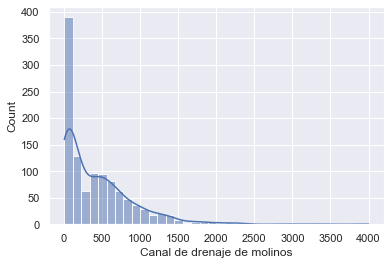

In [3]:
sns.set(style="darkgrid")
sns.histplot(data=df, x="Canal de drenaje de molinos", kde=True)

In [4]:
print("\033[1m Estadísticas de Conductividad: \033[0m")
df["Canal de drenaje de molinos"].describe()

 Estadísticas de Conductividad: 


count    1120.000000
mean      431.454176
std       467.642157
min         5.150888
25%        63.970237
50%       307.551936
75%       656.448845
max      4001.977265
Name: Canal de drenaje de molinos, dtype: float64

### Determinación de Umbral Óptimo

Se aplica una **binarización** a la variable de conductividad. La binarización consiste en *transformar* la variable continua de conductividad a una variable binaria de *presencia* o *no presencia* de conductividad. Esto porque no toda conductividad se debe necesariamente a trazas de azúcar, y en la práctica es más útil definir un límite superior para esta variable. 

La binarización se implementa de forma que: Una **alta conductividad es una clase POSITIVA** y una **baja conductividad es una clase NEGATIVA**.

Adicionalmente, debido a la distribución *sesgada* de la variable de conductividad, es posible que una mala selección del umbral produzca un imbalance en el conjunto de entrenamiento y por lo tanto, métricas de detección del algoritmo que no son óptimas.

#### K-Means Clustering
Para poder distinguir entre clases, se ejecuta un algoritmo de clustering no-supervisado, con el propósito de encontrar **"regiones de operación"** en los datos, y luego verificar si estas regiones tienen en común algún rango de valores de conductividad.

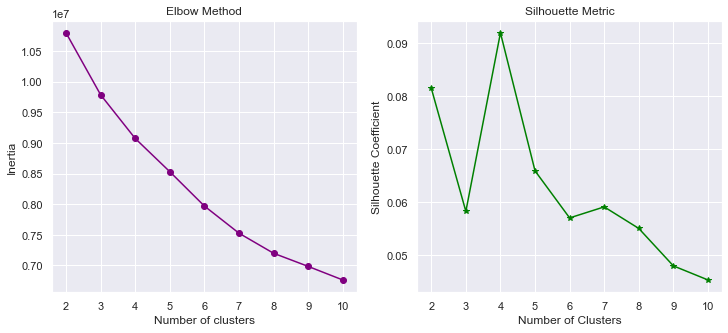

In [5]:
funciones.exploracion_clusters(df)

Puede observarse que **las métricas de cohesión son más altas para 4 agrupaciones**. Se forman los 4 grupos utilizando el algoritmo K-Means, con n=4. Luego, se grafica la serie de tiempo de la conductividad durante la zafra y se colorean las regiones encontradas.

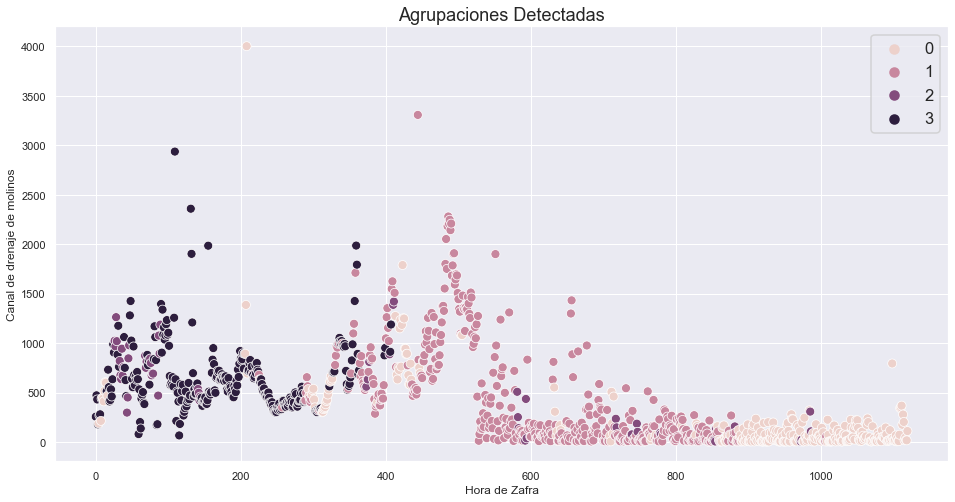

 Medias por Agrupación: 


,Flujo agua asepsia Patio T-A,Flujo agua asepsia Patio T-A_STD,Flujo agua asepsia Molinos T-A,Flujo agua asepsia Molinos T-A_STD,Flujo agua asepsia Molinos T-B,Flujo agua asepsia Molinos T-B_STD,Flujo Agua de Asepsia a Patio T-B,Flujo Agua de Asepsia a Patio T-B_STD,Nivel Chute Molino No. 1 TA,Nivel Chute Molino No. 1 TA_STD,Nivel Chute Molino No. 2 TA,Nivel Chute Molino No. 2 TA_STD,Nivel Chute Molino No. 3 TA,Nivel Chute Molino No. 3 TA_STD,Nivel Chute Molino No. 4 TA,Nivel Chute Molino No. 4 TA_STD,Nivel Chute Molino No. 5 TA,Nivel Chute Molino No. 5 TA_STD,Nivel Chute Molino No. 6 TA,Nivel Chute Molino No. 6 TA_STD,Nivel Chute Molino No. 1 TB,Nivel Chute Molino No. 1 TB_STD,Nivel Chute Molino No. 2 TB,Nivel Chute Molino No. 2 TB_STD,Nivel Chute Molino No. 3 TB,Nivel Chute Molino No. 3 TB_STD,Nivel Chute Molino No. 4 TB,Nivel Chute Molino No. 4 TB_STD,Nivel Chute Molino No. 5 TB,Nivel Chute Molino No. 5 TB_STD,Nivel Chute Molino No. 6 TB,Nivel Chute Molino No. 6 TB_STD,Nivel Tanque Jugo Mezclado TA,Nivel Tanque Jugo Mezclado TA_STD,Nivel Tanque Jugo Filtrado TA,Nivel Tanque Jugo Filtrado TA_STD,Nivel Tanque Jugo Mezclado T-B,Nivel Tanque Jugo Mezclado T-B_STD,Nivel Tanque Jugo Filtrado T-B,Nivel Tanque Jugo Filtrado T-B_STD,Canal de drenaje de molinos,Desbalance Filtrado Mezclado TA,Desbalance Filtrado Mezclado TB
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.460358,0.061363,17.457899,42.593478,14.690028,30.033828,5.505724,11.983414,30.687426,18.190187,27.845241,2.549668,69.035086,12.392358,66.429825,17.409569,64.259465,10.456291,19.265144,4.332786,4.997026,3.191064,23.938527,16.157219,20.050337,7.540879,84.956543,10.571293,75.765691,12.414849,26.940705,23.988828,35.728586,9.269987,44.297705,6.112935,45.904681,3.834283,46.482149,4.420068,205.303836,8.569119,0.577468
1,0.186749,0.031446,16.882816,46.010031,14.857817,35.325907,3.628616,9.238811,6.124859,8.123653,27.691355,2.614233,83.548065,13.047777,80.668865,19.087832,90.745188,4.226313,28.741580,12.451985,17.369721,8.885510,14.920778,7.844835,27.342204,11.253567,58.112062,21.393314,88.925126,5.817858,21.595059,23.029591,36.810255,9.396380,51.385821,10.100209,46.173740,4.524540,45.186575,4.200344,449.544952,14.575566,-0.987165
2,19.022456,2.728746,7.409487,20.456584,5.361832,7.218780,2.301612,6.143532,14.686319,15.068312,55.110634,3.956842,85.914291,7.986957,55.038441,17.692322,89.893389,5.656487,30.314012,10.590339,12.391400,2.517906,15.799491,7.733880,8.357859,7.103503,8.082009,6.908884,35.228978,4.019581,3.351263,3.178442,42.703799,8.308816,55.932311,12.308928,90.307891,9.279897,19.113588,5.057944,548.445720,13.228512,-71.194303
3,26.441558,4.563792,3.942680,14.142220,5.155197,7.593190,3.453858,10.075832,10.719922,13.778152,48.714602,6.392455,82.705710,6.401473,59.993799,23.559509,89.247378,4.443352,31.231461,14.078616,31.991259,13.193065,36.932448,19.127862,66.290114,14.956036,86.743254,18.260330,87.250910,10.815162,47.365345,29.670467,38.548174,10.096974,55.267898,12.663469,49.291381,3.620317,47.198912,4.509568,638.641776,16.719724,-2.092469


 Desviaciones Estándar por Agrupación: 


,Flujo agua asepsia Patio T-A,Flujo agua asepsia Patio T-A_STD,Flujo agua asepsia Molinos T-A,Flujo agua asepsia Molinos T-A_STD,Flujo agua asepsia Molinos T-B,Flujo agua asepsia Molinos T-B_STD,Flujo Agua de Asepsia a Patio T-B,Flujo Agua de Asepsia a Patio T-B_STD,Nivel Chute Molino No. 1 TA,Nivel Chute Molino No. 1 TA_STD,Nivel Chute Molino No. 2 TA,Nivel Chute Molino No. 2 TA_STD,Nivel Chute Molino No. 3 TA,Nivel Chute Molino No. 3 TA_STD,Nivel Chute Molino No. 4 TA,Nivel Chute Molino No. 4 TA_STD,Nivel Chute Molino No. 5 TA,Nivel Chute Molino No. 5 TA_STD,Nivel Chute Molino No. 6 TA,Nivel Chute Molino No. 6 TA_STD,Nivel Chute Molino No. 1 TB,Nivel Chute Molino No. 1 TB_STD,Nivel Chute Molino No. 2 TB,Nivel Chute Molino No. 2 TB_STD,Nivel Chute Molino No. 3 TB,Nivel Chute Molino No. 3 TB_STD,Nivel Chute Molino No. 4 TB,Nivel Chute Molino No. 4 TB_STD,Nivel Chute Molino No. 5 TB,Nivel Chute Molino No. 5 TB_STD,Nivel Chute Molino No. 6 TB,Nivel Chute Molino No. 6 TB_STD,Nivel Tanque Jugo Mezclado TA,Nivel Tanque Jugo Mezclado TA_STD,Nivel Tanque Jugo Filtrado TA,Nivel Tanque Jugo Filtrado TA_STD,Nivel Tanque Jugo Mezclado T-B,Nivel Tanque Jugo Mezclado T-B_STD,Nivel Tanque Jugo Filtrado T-B,Nivel Tanque Jugo Filtrado T-B_STD,Canal de drenaje de molinos,Desbalance Filtrado Mezclado TA,Desbalance Filtrado Mezclado TB
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.688452,0.496183,11.520900,22.742890,10.810744,18.202254,17.073550,28.864149,15.547283,7.384615,11.178064,4.492582,29.066208,9.682823,29.332432,10.220218,31.711330,10.874697,6.017031,4.651829,10.932211,5.576527,23.614761,13.231677,31.739200,10.977039,26.449554,14.107139,21.772407,9.968134,18.339004,9.994727,13.812174,6.533692,8.302687,4.143112,3.709598,4.430484,3.549367,3.060654,357.768649,15.892387,5.147536
1,2.340624,0.393300,14.491870,13.535886,12.369001,14.676837,12.005286,26.791001,8.151586,7.153522,5.416428,5.045190,12.886516,9.064235,15.813340,11.096243,10.956050,6.769845,8.580676,8.015178,16.681216,7.874264,18.465352,10.930050,36.245818,14.949553,32.122253,15.898625,12.779378,6.700794,17.848813,11.817241,9.227823,4.015699,6.830475,4.136647,5.107833,5.068537,5.502674,3.068814,537.099238,6.819732,5.210112
2,19.019939,2.691875,12.038008,25.231686,6.755906,7.276561,7.985865,19.493563,14.209746,10.407242,28.824886,5.446860,14.016502,9.507942,34.326639,11.968916,12.007852,6.322326,11.056128,9.577680,26.797922,6.287786,15.875959,12.943278,15.781044,12.283397,17.195036,13.141821,13.835515,8.220826,3.854800,7.595411,8.067058,6.532945,9.443822,4.731162,14.320988,11.399563,15.043738,6.809258,392.439506,9.505041,19.478863
3,13.665946,2.568753,5.406305,18.295241,3.827602,4.024439,8.751525,24.518040,13.190391,10.371107,25.015076,6.481219,18.479619,7.120591,26.096600,11.156487,14.603421,5.752936,11.764781,8.181307,23.704830,9.852295,28.611837,14.736782,36.485654,15.328757,17.931928,19.007469,14.423838,9.943537,19.681838,7.902190,16.090764,6.269568,10.888137,5.018470,3.714827,4.720310,3.634438,3.017438,345.738763,12.817734,4.542601


In [6]:
funciones.clustering(df,4)

Puede observarse que las agrupaciones 0 y 1 comparten tendencias de conductividad bajas. Existe un valor de aproximadamente 250 a 300 uS de conductividad en estas regiones estables.

Para explorar este umbral de conductividad, se implementa un algoritmo que explora *distintos umbrales de conductividad* y grafica las métricas de entrenamiento para cada selección:

- **Precision:** Habilidad de Clasificador de minimizar Falsos Positivos.
- **Accuracy:** Habilidad del Clasificador de Detectar Verdaderos Positivos y Verdaderos Negativos.
- **Recall:** Habilidad del Clasificador de Detectar Verdaderos Positivos.
- **F1:** Media Ponderada de la Precision y el Recall.
- **Overall:** Media Aritmética de todas las métricas anteriores.


De esta forma, se obtiene una **propuesta de umbral óptima**.

,Precision,Accuracy,F1,Recall,Overall
Umbral Conductividad,,,,,
50.0,0.756796,0.767857,0.850575,0.870588,0.811454
100.0,0.774898,0.776786,0.829157,0.838710,0.804888
200.0,0.830263,0.830357,0.842105,0.849162,0.837972
300.0,0.878003,0.877976,0.876133,0.878788,0.877725
400.0,0.842376,0.842262,0.823920,0.826667,0.833806
500.0,0.780759,0.779762,0.675439,0.681416,0.729344
600.0,0.765998,0.767857,0.524390,0.518072,0.644080


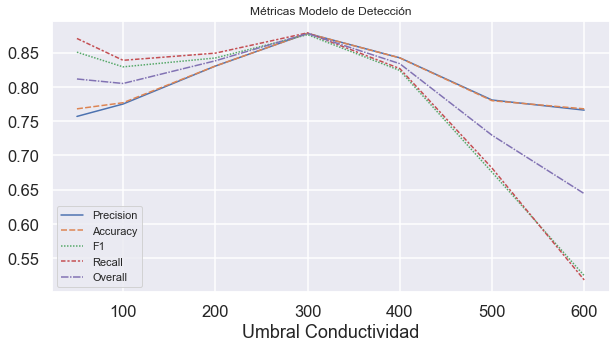

In [7]:
funciones.busqueda_umbral(df,'Canal de drenaje de molinos',[50, 100, 200, 300, 400, 500, 600])

#### Selección de Umbral
El criterio para seleccionar el umbral se propone sea el del **"cima"**. En este método se selecciona un umbral a partir del cual las métricas caen por debajo de un nivel "aceptable".

Por ejemplo, una conductividad de 300 nos proporciona suficiente rango y además las métricas están arriba del 80%.


### Entrenamiento Modelo de Clasificación
Basado en los resultados anteriores, se selecciona un umbral y se entrena el modelo de detección.

In [8]:
# Umbral de Detección
umbral_final = 300

# Binarización y construcción del Dataset de Entrenamiento y Validación
X = df.drop('Canal de drenaje de molinos', axis=1)
y = df['Canal de drenaje de molinos'].apply(lambda x: 1 if x > umbral_final else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

In [9]:
# Estandarización y Entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = LogisticRegression()
model.fit(X_train, y_train)
coefficients = model.coef_[0]

### Métricas Finales de Entrenamiento y Matriz de Confusión
Se muestran las métricas del modelo final y su desempeño para detectar Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos.

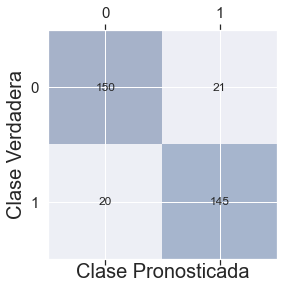

In [10]:
y_pred = model.predict(X_test)

conf_mat = funciones.matriz_confusion(y_test,y_pred)

In [11]:
funciones.metricas_finales(y_test,y_pred,umbral_final)

,Umbral Conductividad,Precision (%),Accuracy (%),F1 (%),Recall (%),Overall (%)
0,300.0,87.800256,87.797619,87.613293,87.878788,87.772489


### Factores de Importancia
Para la determinación de los factores de importancia se presentan dos perspectivas: Importancia por Magnitud del Factor e Importancia por Control del Factor.

#### Importancia por Magnitud del Factor
Esta importancia es el peso relativo que tiene este factor respecto a los demás factores, para contribuir positivamente o negativamente a la conductividad.
Si la contribución es positiva, a mayor magnitud del factor, mayor probabilidad de detectar la clase positiva (mayor probabilidad de alta conductividad).
Si la contribución es negativa, a mayor magnitud del factor, mayor probabilidad de detectar la clase negativa (menor probabilidad de alta conductividad).

<AxesSubplot:ylabel='Variable'>

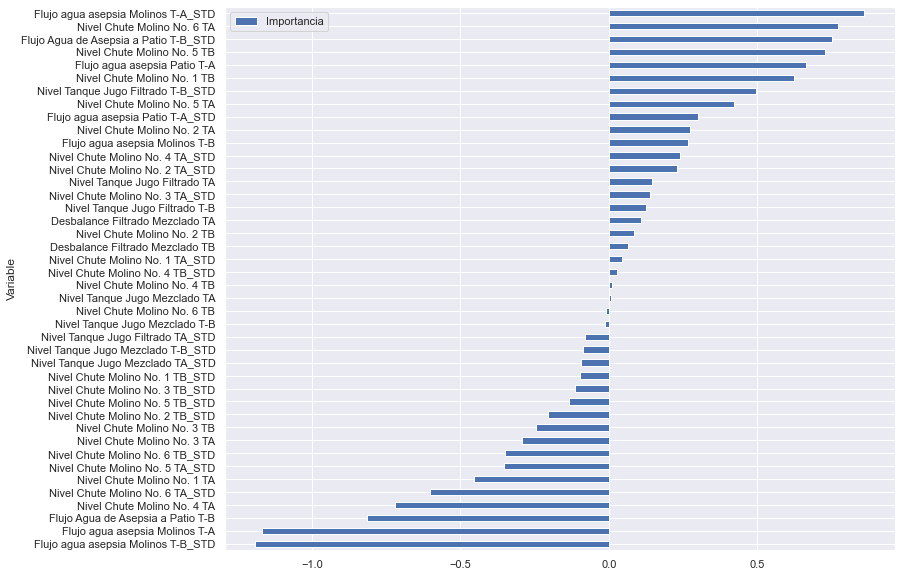

In [12]:
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': coefficients})
feature_importance = feature_importance.sort_values('Importancia', ascending=True)
feature_importance.plot(x='Variable', y='Importancia', kind='barh', figsize=(12, 10))

#### Importancia por Control del Factor
Esta importancia se calcula a partir del efecto que tiene aleatorizar la variable (manteniendo todas las demás constantes) sobre la conductividad. Esto es especialmente importante para identificar **el efecto que tiene la precisión del control de la variable sobre la conductividad final**.

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

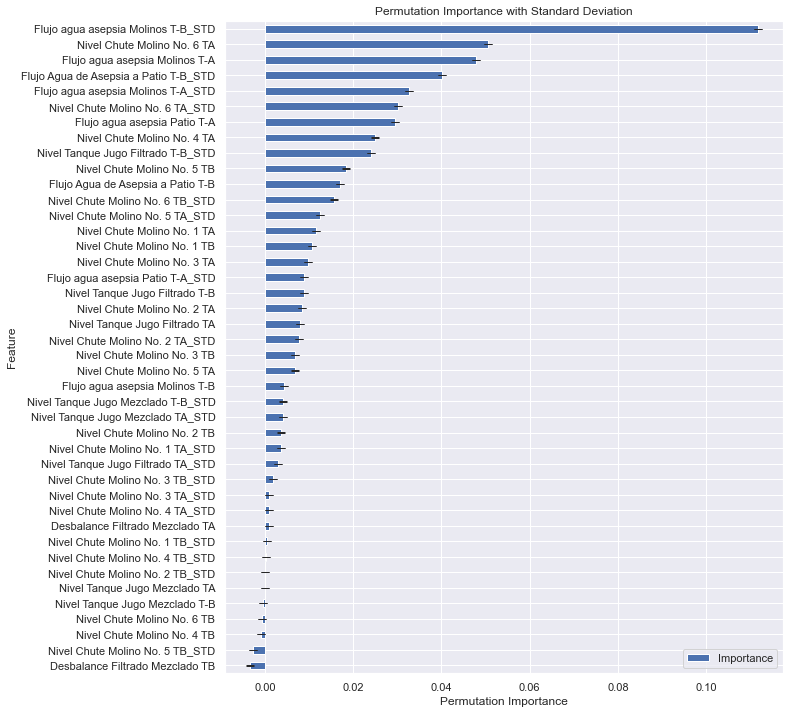

In [13]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 12), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

### Conclusiones:
Dados los factores de importancia identificados, las recomendaciones son como sigue:
- Para los **factores con mayor importancia por magnitud** se recomienda controlar con un **SP menor** (si la importancia por magnitud es **positiva**) o con un **SP mayor** (si la importancia por magnitud es **negativa**) para *reducir la conductividad*.
- Para los **factores con mayor importancia por control** se recomienda **reducir la varianza de la variable** (reducir su variación si es posible por medios manuales o ajustes de los lazos de control involucrados). En el caso de *importancias negativas*, significa que los algoritmos *no encontraron evidencia de que el control de esta variable importe para la conductividad*.